# Continuous Control

### 1. Start the Environment

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


In [2]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

from ddpg_agent import Agent

In [3]:
# select this option to load version 1 (with a single agent) of the environment
# env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [  0.00000000e+00  -4.00000000e+00   0.00000000e+00   1.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.00000000e+01   0.00000000e+00
   1.00000000e+00  -0.00000000e+00  -0.00000000e+00  -4.37113883e-08
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   5.75471878e+00  -1.00000000e+00
   5.55726624e+00   0.00000000e+00   1.00000000e+00   0.00000000e+00
  -1.68164849e-01]


### 3. Take Random Actions in the Environment

In [6]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.07849999824538827


### 4. Train the Agent with DDPG

In [7]:
agent = Agent(state_size=state_size, action_size=action_size, 
              n_agents=num_agents, random_seed=2)

Episode 100	Average Score: 29.56
Episode 102	Average Score: 30.28
Environment solved in 2 episodes!	Average Score: 30.28


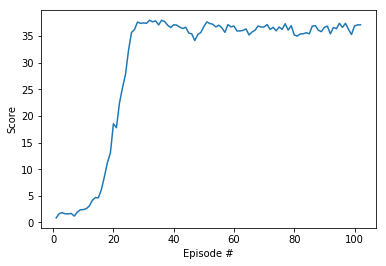

In [8]:
def ddpg(n_episodes=1000, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        state = env_info.vector_observations  
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agent.act(state)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if np.any(done):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)), end="")
        torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
        torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - print_every, np.mean(scores_deque)))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
                      
    return scores  

scores = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 5. Watch a Smart Agent!

In [10]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = agent.act(states)                        # select an action (for each agent)
#     actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 37.49549916191027


In [ ]:
# env.close()